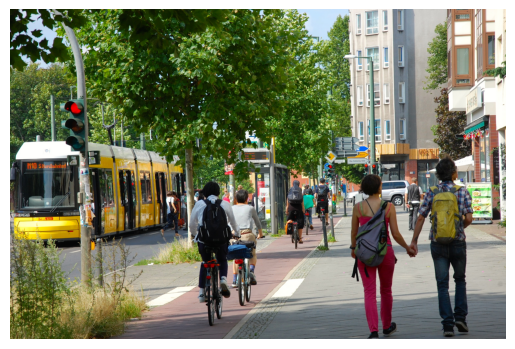

In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
from torchvision.transforms import Compose
import matplotlib.pyplot as plt


from da_od.config import output_img, test_img
from da_od.depth_anything.dpt import DepthAnything
from da_od.depth_anything.util.transform import NormalizeImage, PrepareForNet, Resize


image_path = test_img / "img-00019.jpg"

image = cv2.imread(str(image_path))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

xFormers not available
xFormers not available


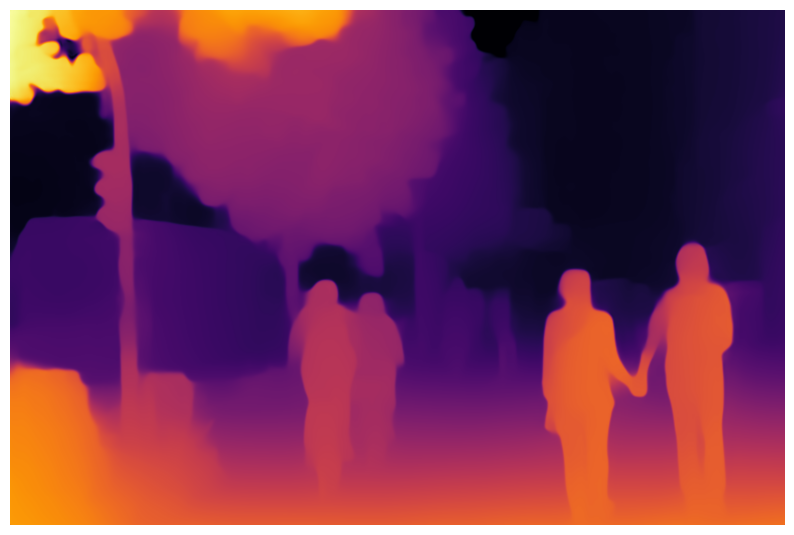

In [2]:
encoder = "vits"  # can also be 'vitb' or 'vitl'
depth_anything = DepthAnything.from_pretrained(
    f"LiheYoung/depth_anything_{encoder}14",
).eval()

transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ],
)

image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB) / 255.0


h, w = image.shape[:2]
image = transform({"image": image})["image"]
image = torch.from_numpy(image).unsqueeze(0)

# depth shape: 1xHxW
with torch.no_grad():
    depth = depth_anything(image)


# Ensure depth has the correct shape (N, C, H, W) before interpolation
if len(depth.shape) == 3:
    depth = depth.unsqueeze(0)  # Add a batch dimension if needed
elif len(depth.shape) == 2:
    depth = depth.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions if needed

# Resizing to original image size
depth = F.interpolate(depth, size=(h, w), mode="bilinear", align_corners=True)

# Saving the raw depth data
raw_depth = depth.cpu().numpy().squeeze()
np.save(output_img / "raw_depth.npy", raw_depth)

# Apply ReLU to ensure all values are non-negative
depth = F.relu(depth)

# Normalize to 0-255 for visualization
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.cpu().numpy().astype(np.uint8).squeeze()

# Apply color map for visualization
depth_colormap = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

plt.figure(figsize=(10, 10))  # You can adjust the figure size as needed
plt.imshow(cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct coloring
plt.axis("off")  # Hide the axis
plt.show()

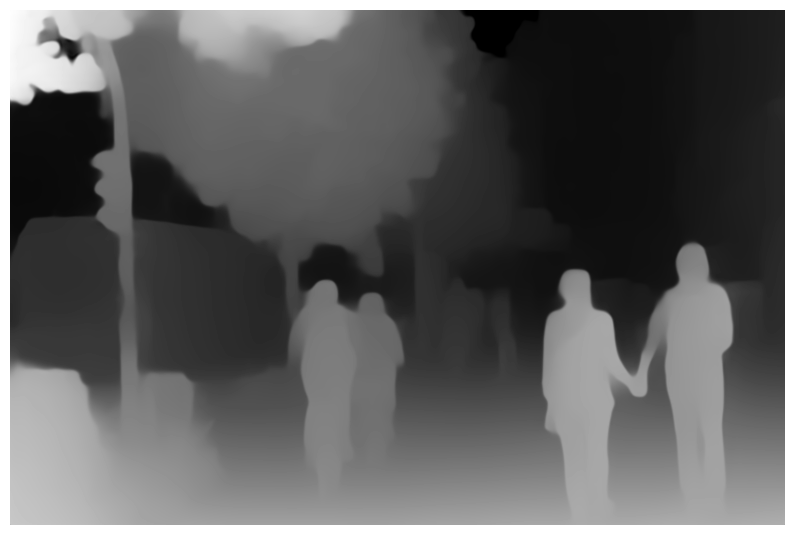

In [3]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
from torchvision.transforms import Compose
import matplotlib.pyplot as plt


from da_od.config import output_img, test_img
from da_od.depth_anything.dpt import DepthAnything
from da_od.depth_anything.util.transform import NormalizeImage, PrepareForNet, Resize

encoder = "vits"  # can also be 'vitb' or 'vitl'
depth_anything = DepthAnything.from_pretrained(
    f"LiheYoung/depth_anything_{encoder}14",
).eval()

transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ],
)

image_path = test_img / "img-00019.jpg"
image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB) / 255.0
h, w = image.shape[:2]
image = transform({"image": image})["image"]
image = torch.from_numpy(image).unsqueeze(0)

# depth shape: 1xHxW
with torch.no_grad():
    depth = depth_anything(image)


# Ensure depth has the correct shape (N, C, H, W) before interpolation
if len(depth.shape) == 3:
    depth = depth.unsqueeze(0)  # Add a batch dimension if needed
elif len(depth.shape) == 2:
    depth = depth.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions if needed

# Resizing to original image size
depth = F.interpolate(depth, size=(h, w), mode="bilinear", align_corners=True)

# Saving the raw depth data
raw_depth = depth.cpu().numpy().squeeze()
np.save(output_img / "raw_depth.npy", raw_depth)

# Apply ReLU to ensure all values are non-negative
depth = F.relu(depth)

# Normalize depth to 0-255 for visualization (this part seems to be already in your code)
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.cpu().numpy().astype(np.uint8).squeeze()

# Display the grayscale depth image
plt.figure(figsize=(10, 10))
plt.imshow(depth, cmap="gray")
plt.axis("off")
plt.show()

The console stream is logged into /Users/maryam/sg_logs/console.log


[2024-02-22 16:52:02] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-22 16:52:02] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-22 16:52:02,961] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-02-22 16:52:05] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-22 16:52:05] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-22 16:52:05] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-02-22 16:52:05] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.
[2024-02-22 16:52:06] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detail

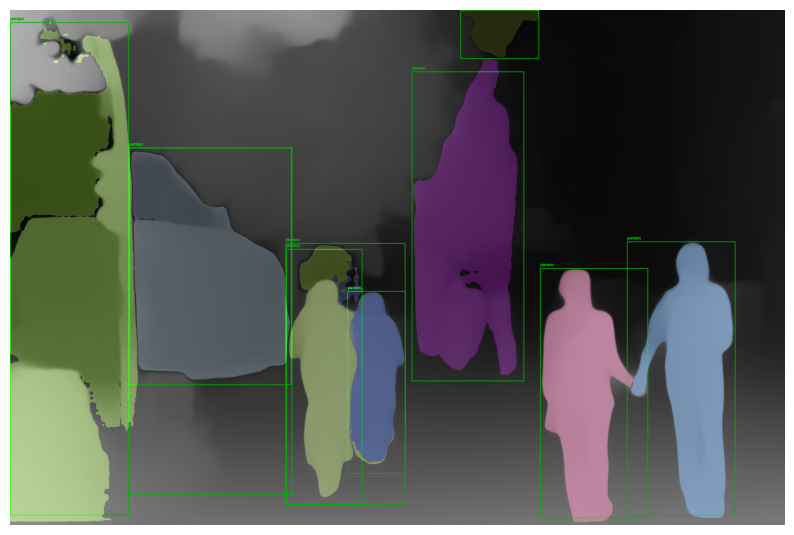

In [4]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# image_path = output_img / "depth_image.png"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, depth = yolo_nas.get_object_detection(depth)

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(depth)
seg_sam.show_anns(mask)

# Create a predictor for SAM
# image = cv2.imread(str(image_path))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(depth)

# Initialize a combined mask
combined_mask = np.zeros((depth.shape[0], depth.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(depth, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        depth,
        class_name,
        (int(x_min), int(y_min) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(depth, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()

[2024-02-22 16:59:09] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-22 16:59:09] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-02-22 16:59:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


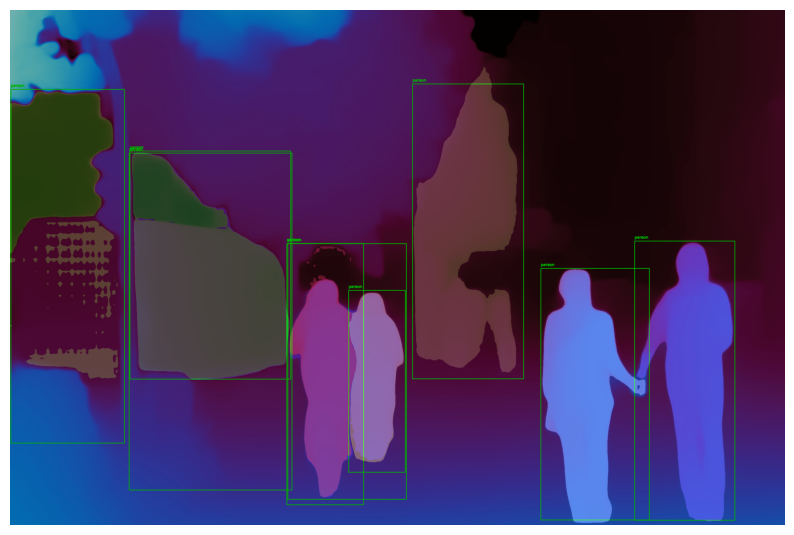

In [5]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# image_path = output_img / "depth_image.png"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, depth = yolo_nas.get_object_detection(depth_colormap)

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(depth_colormap)
seg_sam.show_anns(mask)

# Create a predictor for SAM
# image = cv2.imread(str(image_path))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(depth_colormap)

# Initialize a combined mask
combined_mask = np.zeros((depth_colormap.shape[0], depth_colormap.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(depth_colormap, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        depth_colormap,
        class_name,
        (int(x_min), int(y_min) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(depth_colormap, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()

[2024-02-22 17:21:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-22 17:21:33] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-02-22 17:21:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


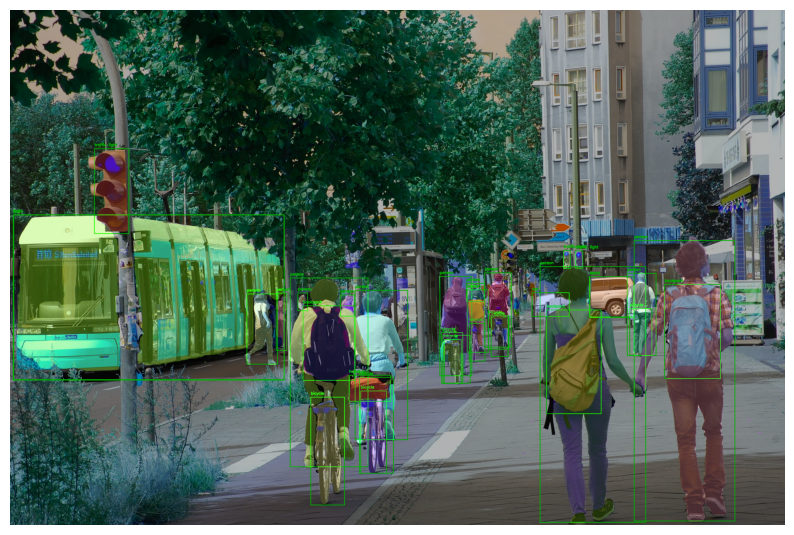

In [9]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

image_path = test_img / "img-00019.jpg"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, image = yolo_nas.get_object_detection(str(image_path))

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(image)
seg_sam.show_anns(mask)

# Create a predictor for SAM
image = cv2.imread(str(image_path))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        image,
        class_name,
        (int(x_min), int(y_min) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()